Install & Setup

In [1]:
# Cell 0: Install all dependencies (once per runtime)
!pip -q install nltk scikit-learn==1.6.0 xgboost==2.0.3 imbalanced-learn==0.12.3 wordcloud==1.9.3 matplotlib seaborn plotly joblib streamlit==1.36.0 emoji==2.12.1

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 8.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.11.0 requires watchdog<

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

Load Data (True.csv + Fake.csv) & Merge

In [2]:
# Cell 1: Load & merge True.csv and Fake.csv (no manual upload)

import pandas as pd
import numpy as np
import os

# ==== এখানে ফাইলের path সেট করুন ====
TRUE_PATH = "/content/True.csv"
FAKE_PATH = "/content/Fake.csv"

# Robust CSV reader (handles encoding issues)
def read_csv_safe(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"❌ File not found: {path}")
    for enc in ['utf-8', 'utf-8-sig', 'latin-1', 'cp1252']:
        try:
            return pd.read_csv(path, encoding=enc, engine='python')
        except Exception:
            continue
    raise ValueError(f"Could not read {path} with common encodings.")

true_df = read_csv_safe(TRUE_PATH)
fake_df = read_csv_safe(FAKE_PATH)

# Detect main text column
def pick_text_column(df):
    candidates = ['text', 'content', 'article', 'body', 'full_text', 'Text', 'CONTENT']
    titles     = ['title', 'headline', 'Title', 'HEADLINE']
    for c in candidates:
        if c in df.columns:
            return c, None
    for t in titles:
        if t in df.columns:
            return None, t
    obj_cols = [c for c in df.columns if df[c].dtype=='O']
    return (obj_cols[0] if obj_cols else df.columns[0]), None

t_text, t_title = pick_text_column(true_df)
f_text, f_title = pick_text_column(fake_df)

# Canonical dataframe builder
def to_canonical(df, txt_col, ttl_col, label_str):
    df = df.copy()
    if txt_col and txt_col in df.columns:
        text = df[txt_col].astype(str)
    elif ttl_col and ttl_col in df.columns:
        text = df[ttl_col].astype(str)
    else:
        text = df.select_dtypes(include='object').iloc[:,0].astype(str)
    if txt_col and ttl_col and (ttl_col in df.columns):
        text = (df[ttl_col].astype(str).fillna('') + ' ' + df[txt_col].astype(str).fillna('')).str.strip()
    out = pd.DataFrame({
        'text': text.fillna('').astype(str)
    })
    out['label_str'] = label_str
    out['label'] = 1 if label_str.lower()=='true' else 0
    return out

true_c = to_canonical(true_df, t_text, t_title, 'True')
fake_c = to_canonical(fake_df, f_text, f_title, 'Fake')

# Merge & clean
data = pd.concat([true_c, fake_c], axis=0, ignore_index=True)
data.drop_duplicates(subset=['text'], inplace=True)
data = data[(data['text'].str.len() > 5)]

print("✅ Shape:", data.shape)
print(data['label_str'].value_counts())
data.head(3)


✅ Shape: (38643, 3)
label_str
True    21191
Fake    17452
Name: count, dtype: int64


,text,label_str,label
0,WASHINGTON (Reuters) - The head of a conservat...,True,1
1,WASHINGTON (Reuters) - Transgender people will...,True,1
2,WASHINGTON (Reuters) - The special counsel inv...,True,1


Quick EDA & Visualization

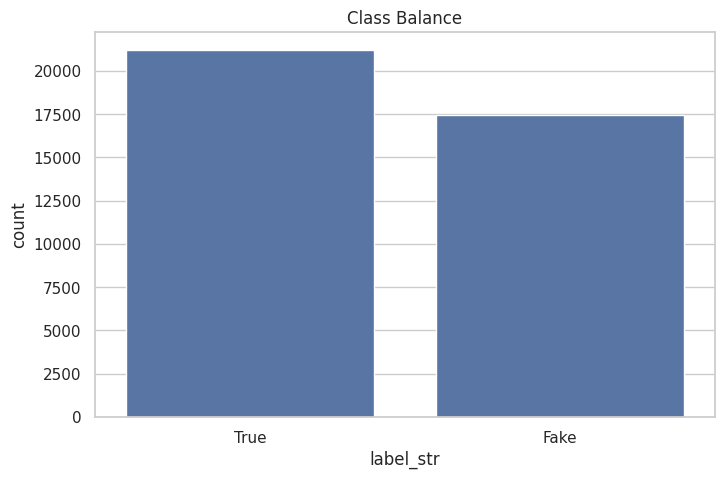

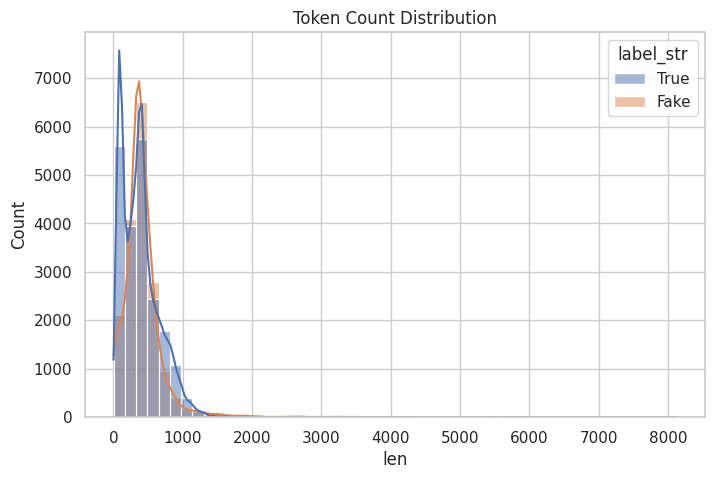

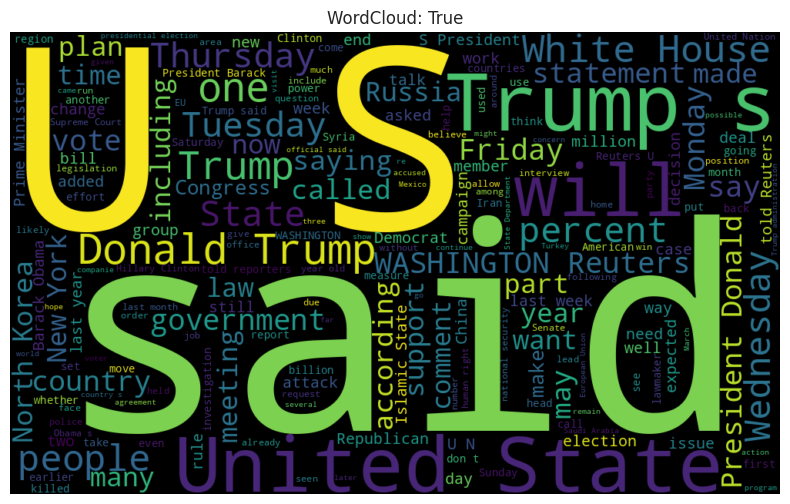

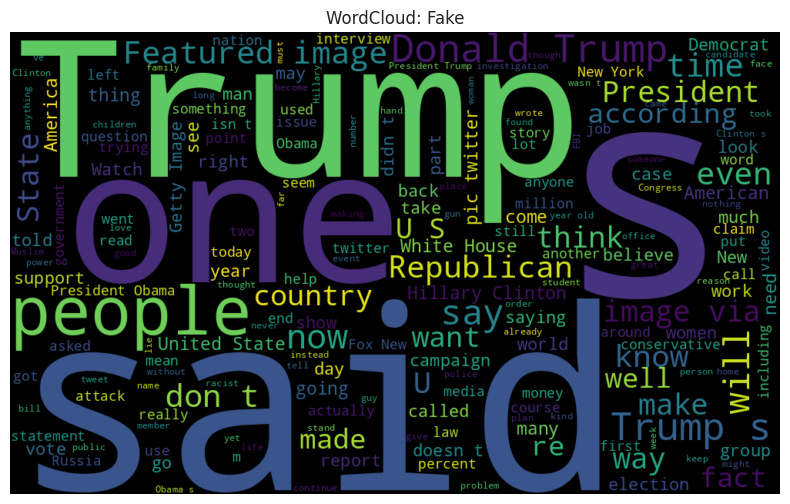

Top n-grams (True):


,ngram,count
0,said,97814
1,trump,54073
2,reuters,28652
3,president,27855
4,state,20781
5,government,18550
6,new,16735
7,house,16462
8,states,16411
9,republican,16135


Top n-grams (Fake):


,ngram,count
0,trump,68072
1,said,24803
2,people,21187
3,president,20790
4,just,16742
5,donald,15285
6,like,14358
7,donald trump,14025
8,clinton,13529
9,obama,13378


In [3]:
# Cell 2: Class balance, length dist, wordclouds, top n-grams
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px
import re

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (8,5)

# Class balance
ax = sns.countplot(x='label_str', data=data)
plt.title('Class Balance')
plt.show()

# Text length distribution
data['len'] = data['text'].str.split().apply(len)
sns.histplot(data, x='len', hue='label_str', bins=50, kde=True)
plt.title('Token Count Distribution')
plt.show()

# WordClouds
stop_words = set(STOPWORDS)
for cls in ['True','Fake']:
    txt = ' '.join(data.loc[data['label_str']==cls, 'text'].astype(str).values)
    txt = re.sub(r'http\S+|www\.\S+',' ', txt)
    wc = WordCloud(width=1000, height=600, stopwords=stop_words, max_words=200).generate(txt)
    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off'); plt.title(f'WordCloud: {cls}')
    plt.show()

# Top n-grams (quick view)
from sklearn.feature_extraction.text import CountVectorizer

def top_ngrams(texts, n=20, ngram_range=(1,2)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english', min_df=2)
    X = vec.fit_transform(texts)
    sums = np.array(X.sum(axis=0)).ravel()
    idx = sums.argsort()[::-1][:n]
    vocab = np.array([t for t,_ in sorted(vec.vocabulary_.items(), key=lambda x:x[1])])
    return pd.DataFrame({'ngram': vocab[idx], 'count': sums[idx]})

print("Top n-grams (True):")
display(top_ngrams(data.loc[data.label_str=='True','text']))

print("Top n-grams (Fake):")
display(top_ngrams(data.loc[data.label_str=='Fake','text']))


Text Preprocessing Utilities

In [4]:
# Cell 3: Cleaner function (light but effective)
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

en_stops = set(stopwords.words('english'))
lemm = WordNetLemmatizer()

def clean_text(s:str) -> str:
    s = s.lower()
    s = re.sub(r'<[^>]+>', ' ', s)         # HTML
    s = re.sub(r'http\S+|www\.\S+', ' ', s) # URLs
    s = re.sub(r'[^a-z\s]', ' ', s)        # keep letters
    s = re.sub(r'\s+', ' ', s).strip()
    tokens = [lemm.lemmatize(w) for w in s.split() if w not in en_stops]
    return ' '.join(tokens)

# Optional preview
data['clean'] = data['text'].astype(str).apply(clean_text)
data[['text','clean']].head(3)


,text,clean
0,WASHINGTON (Reuters) - The head of a conservat...,washington reuters head conservative republica...
1,WASHINGTON (Reuters) - Transgender people will...,washington reuters transgender people allowed ...
2,WASHINGTON (Reuters) - The special counsel inv...,washington reuters special counsel investigati...


Train/Test Split

In [5]:
# Cell 4: Split
from sklearn.model_selection import train_test_split

X = data['clean'].values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

len(X_train), len(X_test), y.mean()


(30914, 7729, np.float64(0.5483787490619259))

Build & Evaluate Multiple Models (TF-IDF + Classifiers)

In [7]:
# Cell 5: Multiple models with identical TF-IDF
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
# Removed problematic tree-based models: RandomForestClassifier, GradientBoostingClassifier, XGBClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report
import joblib
import os

tfidf = TfidfVectorizer(
    max_features=200000,
    ngram_range=(1,2),
    sublinear_tf=True,
    min_df=2
)

models = {
    "LogReg": LogisticRegression(max_iter=4000, n_jobs=-1, C=2.0, solver='liblinear'),
    "LinearSVC": LinearSVC(),
    "SGD": SGDClassifier(loss='log_loss', max_iter=2000, n_jobs=-1),
    "MNB": MultinomialNB(),
    "CNB": ComplementNB(),


}

results = []
trained = {}

for name, clf in models.items():
    pipe = Pipeline([('tfidf', tfidf), ('clf', clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    # Proba or decision scores for AUC
    try:
        y_prob = pipe.predict_proba(X_test)[:,1]
    except Exception:
        try:
            from sklearn.utils.extmath import softmax
            scores = pipe.decision_function(X_test)
            # minmax -> prob-ish
            mn, mx = scores.min(), scores.max()
            y_prob = (scores - mn) / (mx - mn + 1e-9)
        except Exception:
            y_prob = None

    acc = accuracy_score(y_test, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    results.append([name, acc, pr, rc, f1, auc])
    trained[name] = pipe
    print(f"✅ {name}: acc={acc:.4f} f1={f1:.4f} auc={auc:.4f}")

results_df = pd.DataFrame(results, columns=['Model','Accuracy','Precision','Recall','F1','ROC_AUC']).sort_values('F1', ascending=False)
results_df

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


✅ LogReg: acc=0.9887 f1=0.9898 auc=0.9992
✅ LinearSVC: acc=0.9946 f1=0.9951 auc=0.9998
✅ SGD: acc=0.9812 f1=0.9831 auc=0.9978
✅ MNB: acc=0.9551 f1=0.9595 auc=0.9899
✅ CNB: acc=0.9574 f1=0.9614 auc=0.9899


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
1,LinearSVC,0.994566,0.992026,0.998112,0.995060,0.999831
0,LogReg,0.988744,0.983236,0.996461,0.989804,0.999218
2,SGD,0.981239,0.972960,0.993393,0.983071,0.997826
4,CNB,0.957433,0.956766,0.966022,0.961371,0.989947
3,MNB,0.955104,0.949411,0.969797,0.959496,0.989947


/tmp/ipython-input-1933840537.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')


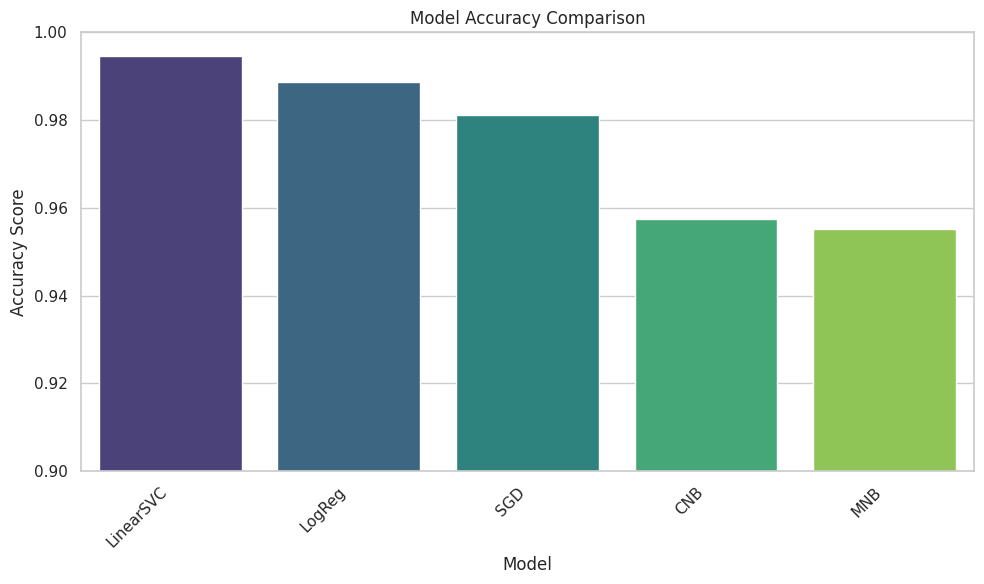

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.ylim(0.9, 1.0) # Set y-axis limits for better visualization of high accuracies
plt.ylabel('Accuracy Score')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Pick Best, Detailed Report & Save Artifacts

🏆 Best model: LinearSVC

Classification Report:

              precision    recall  f1-score   support

     Fake(0)       1.00      0.99      0.99      3491
     True(1)       0.99      1.00      1.00      4238

    accuracy                           0.99      7729
   macro avg       0.99      0.99      0.99      7729
weighted avg       0.99      0.99      0.99      7729



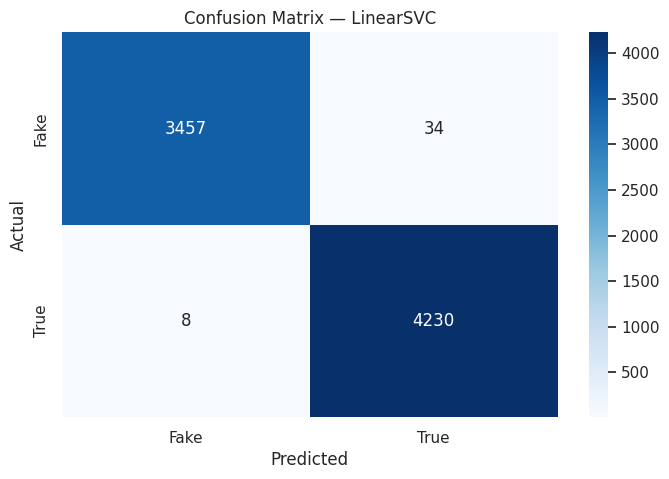

💾 Saved: models/best_pipeline_LinearSVC.joblib


In [8]:
# Cell 6: Best model, report, confusion matrix, save .joblib
best_name = results_df.iloc[0]['Model']
best_pipe = trained[best_name]
print("🏆 Best model:", best_name)

y_pred = best_pipe.predict(X_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Fake(0)','True(1)']))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake','True'], yticklabels=['Fake','True'])
plt.title(f'Confusion Matrix — {best_name}')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

os.makedirs('models', exist_ok=True)
joblib.dump(best_pipe, f'models/best_pipeline_{best_name}.joblib')
results_df.to_csv('models/all_model_scores.csv', index=False)
print("💾 Saved:", f'models/best_pipeline_{best_name}.joblib')


Streamlit UI

In [9]:
# Cell 8: Write a gorgeous Streamlit app (app.py)
%%writefile app.py
import streamlit as st
import joblib, os, json, time, re
import numpy as np
import pandas as pd
from emoji import emojize

APP_TITLE = "📰 Fake / Truth News Detector"
SUBTITLE = "TF-IDF + Multiple ML Models → Best Model Deployed"

# ========== Styling ==========
st.set_page_config(page_title="Fake/Truth Detector", page_icon="📰", layout="wide")

CSS = """
<style>
/* Gradient background + glass cards */
.reportview-container .main, .block-container {
  background: linear-gradient(135deg, #0f172a 0%, #1e293b 40%, #0b132b 100%);
  color: #e5e7eb;
}
h1, h2, h3, h4, h5 { color: #f8fafc; }
.sidebar .sidebar-content { background: #0b132b; }
.stTextInput>div>div>input, .stTextArea textarea {
  background: rgba(255,255,255,0.05) !important;
  border-radius: 14px !important;
}
.glass {
  background: rgba(255,255,255,0.06);
  border: 1px solid rgba(255,255,255,0.15);
  box-shadow: 0 10px 25px rgba(0,0,0,0.25);
  backdrop-filter: blur(8px);
  border-radius: 16px;
  padding: 18px;
}
.tag {
  display:inline-block; padding:6px 10px; border-radius:999px;
  background: rgba(255,255,255,0.08); margin-right:6px; font-size:0.85rem;
}
.pred-true  { background: linear-gradient(90deg, #22c55e, #16a34a); }
.pred-fake  { background: linear-gradient(90deg, #ef4444, #dc2626); }
.kpi {
  background: rgba(255,255,255,0.05);
  border-radius: 16px; padding: 16px; text-align:center;
}
.kpi h3 { margin: 0; font-size: 0.95rem; color: #cbd5e1; }
.kpi p  { font-size: 1.4rem; margin: 4px 0 0 0; color: #f8fafc; }
a { color: #93c5fd; }
</style>
"""
st.markdown(CSS, unsafe_allow_html=True)

# ========== Load Best Model ==========
@st.cache_resource
def load_best():
    # pick any best_* if present
    model_dir = 'models'
    if not os.path.exists(model_dir):
        st.error("No model found. Please train in the notebook first.")
        st.stop()
    cands = [f for f in os.listdir(model_dir) if f.startswith('best_pipeline_') and f.endswith('.joblib')]
    if not cands:
        st.error("No saved pipeline found. Train & export first.")
        st.stop()
    # choose the latest saved
    cands.sort(key=lambda x: os.path.getmtime(os.path.join(model_dir, x)), reverse=True)
    pipe = joblib.load(os.path.join(model_dir, cands[0]))
    name = cands[0].replace('best_pipeline_','').replace('.joblib','')
    return pipe, name

pipe, best_name = load_best()

# ========== Header ==========
st.title(APP_TITLE)
st.write(f"**{SUBTITLE}**  — Deployed model: `{best_name}`")

colA, colB, colC = st.columns(3)
with colA:
    st.markdown('<div class="kpi"><h3>Vectorizer</h3><p>TF-IDF (1–2 gram)</p></div>', unsafe_allow_html=True)
with colB:
    st.markdown(f'<div class="kpi"><h3>Classifier</h3><p>{best_name}</p></div>', unsafe_allow_html=True)
with colC:
    st.markdown('<div class="kpi"><h3>Batch</h3><p>CSV Upload</p></div>', unsafe_allow_html=True)

st.markdown("---")

# ========== Tabs ==========
tab1, tab2 = st.tabs(["🔎 Predict", "📦 Batch & Download"])

with tab1:
    st.subheader("Post the full news📰")
    user_text = st.text_area("Paste news content or headline here:", height=200, placeholder="Type/paste your news text...")
    btn = st.button("Analyze")
    if btn and user_text.strip():
        with st.spinner("Scoring..."):
            # Predict
            try:
                proba = None
                y_pred = pipe.predict([user_text])[0]
                try:
                    proba = pipe.predict_proba([user_text])[0][1]  # prob of True
                except Exception:
                    # decision_function to pseudo-prob
                    try:
                        score = pipe.decision_function([user_text])[0]
                        proba = 1/(1+np.exp(-score))
                    except Exception:
                        proba = None

                label = "True" if y_pred==1 else "Fake"
                conf  = f"{proba*100:.2f}%" if proba is not None else "—"

                color_class = "pred-true" if y_pred==1 else "pred-fake"
                st.markdown(f'<div class="glass {color_class}"><h2 style="margin:0;">Prediction: {label} {emojize(":white_check_mark:" if y_pred==1 else ":cross_mark:")}</h2><p style="margin:6px 0 0 0;">Confidence: <b>{conf}</b></p></div>', unsafe_allow_html=True)

                # Token contributions (if linear model)
                if hasattr(pipe.named_steps['clf'], 'coef_'):
                    vect = pipe.named_steps['tfidf']
                    clf  = pipe.named_steps['clf']
                    x = vect.transform([user_text])
                    coef = clf.coef_.ravel()
                    contrib = x.multiply(coef)
                    contrib = np.asarray(contrib.todense()).ravel()
                    vocab = vect.get_feature_names_out()
                    top_idx = np.argsort(contrib)[-10:][::-1]
                    top_tokens = [(vocab[i], float(contrib[i])) for i in top_idx if contrib[i] > 0]
                    if top_tokens:
                        st.write("**Top positive tokens:**")
                        for tok, val in top_tokens:
                            st.markdown(f'<span class="tag">{tok}</span>', unsafe_allow_html=True)
                else:
                    st.caption("Token-level explanation available for linear models.")
            except Exception as e:
                st.error(f"Error: {e}")

with tab2:
    st.subheader("Batch Predict (CSV)")
    st.write("Upload a CSV with a column named `text` (or `title`).")
    up = st.file_uploader("Upload CSV", type=['csv'])
    if up is not None:
        try:
            df = pd.read_csv(up)
            # robust pick
            text_col = None
            for c in ['text','content','article','body','title','headline']:
                if c in df.columns:
                    text_col = c; break
            if text_col is None:
                st.error("No text/title-like column found.")
            else:
                preds = pipe.predict(df[text_col].astype(str).fillna(''))
                try:
                    probs = pipe.predict_proba(df[text_col].astype(str).fillna(''))[:,1]
                except Exception:
                    # decision_function fallback
                    try:
                        scores = pipe.decision_function(df[text_col].astype(str).fillna(''))
                        probs = 1/(1+np.exp(-scores))
                    except:
                        probs = np.full(len(preds), np.nan)

                out = df.copy()
                out['pred_label'] = np.where(preds==1, 'True', 'Fake')
                out['pred_prob_true'] = probs
                st.success("Done.")
                st.dataframe(out.head(20))
                csv = out.to_csv(index=False).encode()
                st.download_button("⬇️ Download Predictions", csv, "predictions.csv", "text/csv")
        except Exception as e:
            st.error(f"Failed to process: {e}")

st.markdown("---")
st.caption("Built with ❤️ Streamlit · TF-IDF · Scikit-learn · XGBoost")


Writing app.py


In [13]:
!ngrok config add-authtoken 2zUHPKEaHnp4MN5L09ImZ84L4ay_3b3kGUZDfK175M6qzXo16


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [14]:
# Cell 9B: Launch Streamlit via ngrok (if you have a token)
!pip -q install pyngrok
from pyngrok import ngrok
import os
os.environ["PYNGROK_DEFAULT_REGION"] = "ap"
# ngrok.set_auth_token("YOUR_NGROK_AUTHTOKEN")  # <- set if you have one
public_url = ngrok.connect(8501)
get_ipython().system_raw('streamlit run app.py --server.port 8501 --server.headless true &')
public_url


<NgrokTunnel: "https://99753cc60056.ngrok-free.app" -> "http://localhost:8501">